In [221]:
import sys
print(sys.version)

3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]


In [222]:
import torch
print(torch.__version__)

2.1.1+cu118


In [223]:
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm
import numpy as np

In [224]:
cora_dataset = Planetoid('/tmp/cora', 'cora')

In [225]:
cora_data = cora_dataset[0]

In [226]:
# For debug use only
num_nodes = cora_data.num_nodes
print('cora has {} nodes'.format(num_nodes))

num_edges = cora_data.num_edges
print('cora has {} edges'.format(num_edges))

cora has 2708 nodes
cora has 10556 edges


In [227]:
# For debug use only
print(cora_data)
print(cora_data.x.device)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
cpu


In [228]:
# For debug use only
cora_x_train = cora_data.x[cora_data.train_mask]
cora_x_val = cora_data.x[cora_data.val_mask]
cora_x_test = cora_data.x[cora_data.test_mask]

print("number of nodes in cora train set,", cora_x_train.shape[0])
print("number of nodes in cora val set,", cora_x_val.shape[0])
print("number of nodes in cora test set,", cora_x_test.shape[0])

number of nodes in cora train set, 140
number of nodes in cora val set, 500
number of nodes in cora test set, 1000


In [229]:
# For debug use only
print(cora_data.y)
print(cora_data.y.shape)
s = set()
histogram = np.zeros(7)
for label in cora_data.y:
    s.add(label.item())
    histogram[label.item()]+=1
print(s)
print(histogram)

tensor([3, 4, 4,  ..., 3, 3, 3])
torch.Size([2708])
{0, 1, 2, 3, 4, 5, 6}
[351. 217. 418. 818. 426. 298. 180.]


In [230]:
# For debug use only
print(cora_data.x.shape)
print(cora_data.x[170:180])
print(cora_data.num_features)
print(cora_data.num_nodes)
print(cora_data.num_node_types)
print(type(cora_data))

torch.Size([2708, 1433])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
1433
2708
1
<class 'torch_geometric.data.data.Data'>


In [231]:
# Define the GAT model
class GAT(torch.nn.Module):
    # hidden channels will be the embedding dimension for each attention head
    # after applying the first GAT layer.
    def __init__(self, in_channels, hidden_channels, 
                 num_heads, dropout_rate, num_classes):
        super().__init__()
        
        self.dropout_rate = dropout_rate
        
        self.hidden_channels = hidden_channels
        self.num_heads = num_heads
        
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads, 
                                dropout=dropout_rate)
        self.conv2 = GATConv(hidden_channels*num_heads, num_classes, 
                                dropout=dropout_rate, concat=False)

    def forward(self, x, edge_index):
        out = F.dropout(x, p=self.dropout_rate, training=self.training)
        
        out = self.conv1(out, edge_index)
        assert out.shape[-1] == self.hidden_channels * self.num_heads
        
        out = F.elu(out)
        out = F.dropout(out, p=self.dropout_rate, training=self.training)
        
        out = self.conv2(out, edge_index)
        return out

In [232]:
def train(model, data, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()
    
    pred = model(data.x, data.edge_index)
    loss = loss_fn(pred[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    return loss

In [233]:
@torch.no_grad()
def evaluate(model, data, test_mask, loss_fn):
    accuracy_list = [0.0, 0.0]
    loss_list = [0.0, 0.0]
    model.eval()

    logits = model(data.x, data.edge_index)
    pred = logits.argmax(dim=-1)
    
    for i, mask in enumerate([data.train_mask, test_mask]):
        accuracy_list[i] = pred[mask].eq(data.y[mask]).float().mean().item()
        loss_list[i] = loss_fn(logits[mask], data.y[mask]).item()

    return accuracy_list, loss_list

In [234]:
def summarize(model):
    num_params = 0
    print(f"Model Summary: {type(model).__name__}\n")
    for name, param in model.named_parameters():
        print(name, param.size())
        num_params += param.numel()
    print(f"\nTotal number of params: {num_params}")

In [347]:
def train_model(model, data, optimizer, loss_fn, save_name, num_epochs=1000, 
                log_freq=50, patience=100, logging=True):
    print(f"Using {device}, model: {next(model.parameters()).device}, data: {data.x.device}")
    
    # Early stopping initialization
    best_val_loss = float('inf')
    best_val_acc = 0.0
    patience_counter = 0
    best_epoch = 0
    best_model_state = None
    
    # Evaluate before training
    if logging:
        acc_list, loss_list = evaluate(model, data, data.val_mask, loss_fn)
        print("Before training: ")
        print(f"Train Acc: {acc_list[0]:.4f}, Train Loss: {loss_list[0]:.4f}, Val Acc: {acc_list[1]:.4f}, Val Loss: {loss_list[1]:.4f}\n")
    
    # Start training
    for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
        loss = train(model, data, optimizer, loss_fn)
        acc_list, loss_list = evaluate(model, data, 
                                       data.val_mask, loss_fn)
    
        # Update early stopping criteria
        val_loss = loss_list[1]
        val_acc = acc_list[1]
        if val_loss < best_val_loss or val_acc > best_val_acc:
            best_val_loss = min(best_val_loss, val_loss)
            best_val_acc = max(best_val_acc, val_acc)
            patience_counter = 0
            best_epoch = epoch
            torch.save(model.state_dict(), save_name)
        else:
            patience_counter += 1
    
        # Check if patience limit is reached
        if patience_counter >= patience:
            if logging: print(f"\nEarly stopping triggered at epoch {epoch + 1}")
            break
            
        # Logging
        if logging and ((epoch % log_freq == 0) or (epoch + 1 == num_epochs)):
            print(f"Epoch: {epoch+1}, Loss: {loss:.4f}")
            print(f"    Eval: Train Acc: {acc_list[0]:.4f}, Train Loss: {loss_list[0]:.4f}, Val Acc: {acc_list[1]:.4f}, Val Loss: {loss_list[1]:.4f}")

    if best_model_state is not None:
        model.load_state_dict(best_model_state["state_dict"])
        
    print(f"\nTraining completed.\nBest Validation at Epoch: {best_epoch + 1}\nBest Val Acc: {best_val_acc:.4f}, Best Val Loss: {best_val_loss:.4f}\n")

In [257]:
# device = torch.device("cpu")
# device = torch.device("cuda")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_heads = 8
dropout_rate = 0.4
emb_dim1 = 8
lr = 0.005

cora_num_classes = len(cora_data.y.unique())
assert cora_num_classes == 7

In [258]:
num_epochs = 1000
log_freq = 50

cora_model = GAT(cora_data.num_features, emb_dim1, num_heads, dropout_rate, 
            cora_num_classes).to(device)
cora_data.to(device)

lambda_l2 = 0.001
cora_optimizer = torch.optim.Adam(cora_model.parameters(), lr=lr, weight_decay=lambda_l2)
loss_fn = nn.CrossEntropyLoss()

In [259]:
train_model(cora_model, cora_data, cora_optimizer, loss_fn, "cora_model_01.pth", num_epochs, log_freq, patience=100)
cora_model.load_state_dict(torch.load("cora_model_01.pth", map_location=device))
cora_model = cora_model.to(device)

Using cuda

model devide: cuda:0
Before training: 
Train Acc: 0.1429, Train Loss: 1.9503, Val Acc: 0.1180, Val Loss: 1.9536



Training Epochs:   1%|          | 9/1000 [00:00<00:11, 86.93it/s]

Epoch: 1, Loss: 1.9449
    Eval: Train Acc: 0.6786, Train Loss: 1.7709, Val Acc: 0.5180, Val Loss: 1.8389


Training Epochs:   8%|▊         | 81/1000 [00:00<00:06, 143.41it/s]

Epoch: 51, Loss: 0.1804
    Eval: Train Acc: 1.0000, Train Loss: 0.0240, Val Acc: 0.7820, Val Loss: 0.7323


Training Epochs:  14%|█▍        | 139/1000 [00:00<00:04, 173.19it/s]

Epoch: 101, Loss: 0.1568
    Eval: Train Acc: 1.0000, Train Loss: 0.0104, Val Acc: 0.7820, Val Loss: 0.7416


Training Epochs:  18%|█▊        | 177/1000 [00:01<00:04, 182.34it/s]

Epoch: 151, Loss: 0.1768
    Eval: Train Acc: 1.0000, Train Loss: 0.0055, Val Acc: 0.7880, Val Loss: 0.7572


Training Epochs:  24%|██▎       | 237/1000 [00:01<00:03, 193.62it/s]

Epoch: 201, Loss: 0.0734
    Eval: Train Acc: 1.0000, Train Loss: 0.0048, Val Acc: 0.7840, Val Loss: 0.8094


Training Epochs:  25%|██▌       | 251/1000 [00:01<00:04, 165.91it/s]

Epoch: 251, Loss: 0.1309
    Eval: Train Acc: 1.0000, Train Loss: 0.0040, Val Acc: 0.7780, Val Loss: 0.7363
Early stopping triggered at epoch 252

Training completed.
Best Validation at Epoch: 152
Best Val Acc: 0.7940, Best Val Loss: 0.7211


In [260]:
# Evaluate after training
acc_list, loss_list = evaluate(cora_model, cora_data, cora_data.val_mask, loss_fn)
print("After training: ")
print(f"Train Acc: {acc_list[0]:.4f}, Train Loss: {loss_list[0]:.4f}, Val Acc: {acc_list[1]:.4f}, Val Loss: {loss_list[1]:.4f}\n")

After training: 
Train Acc: 1.0000, Train Loss: 0.0056, Val Acc: 0.7940, Val Loss: 0.7617



In [261]:
cite_dataset = Planetoid('/tmp/Citeseer', 'Citeseer')
cite_data = cite_dataset[0]

Processing...
Done!


In [275]:
# For debug use only
print(f"Number of nodes: {cite_data.num_nodes}")
print(f"Number of features per node: {cite_data.num_node_features}")
print(f"Number of edges: {cite_data.num_edges}")
print(f"Number of undirectd edge: {cite_data.edge_index.shape[1]//2}")
print(f"Number of classes: {len(cite_data.y.unique())}")

Number of nodes: 3327
Number of features per node: 3703
Number of edges: 9104
Number of undirectd edge: 4552
Number of classes: 6


In [276]:
# For debug use only
cite_x_train = cite_data.x[cite_data.train_mask]
cite_x_val = cite_data.x[cite_data.val_mask]
cite_x_test = cite_data.x[cite_data.test_mask]

print("number of nodes in cora train set,", cite_x_train.shape[0])
print("number of nodes in cora val set,", cite_x_val.shape[0])
print("number of nodes in cora test set,", cite_x_test.shape[0])

number of nodes in cora train set, 120
number of nodes in cora val set, 500
number of nodes in cora test set, 1000


In [292]:
cite_num_classes = len(cite_data.y.unique())
assert cite_num_classes == 6

cite_model = GAT(cite_data.num_features, emb_dim1, num_heads, dropout_rate, 
            cite_num_classes).to(device)
cite_data.to(device)

# Create optimizer for citeseer
cite_optimizer = torch.optim.Adam(cite_model.parameters(), lr=lr, weight_decay=lambda_l2)

# Train citeseer model
train_model(cite_model, cite_data, cite_optimizer, loss_fn, "cite_model_01.pth", num_epochs=1000, log_freq=10, patience=100)
cite_model.load_state_dict(torch.load("cite_model_01.pth", map_location=device))
cite_model = cite_model.to(device)

# Evaluate after training
acc_list, loss_list = evaluate(cite_model, cite_data, cite_data.val_mask, loss_fn)
print("\nAfter training: ")
print(f"Train Acc: {acc_list[0]:.4f}, Train Loss: {loss_list[0]:.4f}, Val Acc: {acc_list[1]:.4f}, Val Loss: {loss_list[1]:.4f}\n")

Using cuda

model devide: cuda:0
Before training: 
Train Acc: 0.1917, Train Loss: 1.7921, Val Acc: 0.1180, Val Loss: 1.8114



Training Epochs:   1%|          | 8/1000 [00:00<00:12, 79.41it/s]

Epoch: 1, Loss: 1.7908
    Eval: Train Acc: 0.8000, Train Loss: 1.5142, Val Acc: 0.5600, Val Loss: 1.6660
Epoch: 11, Loss: 0.4038
    Eval: Train Acc: 0.9833, Train Loss: 0.1888, Val Acc: 0.6940, Val Loss: 0.9905


Training Epochs:   5%|▌         | 52/1000 [00:00<00:06, 141.71it/s]

Epoch: 21, Loss: 0.2961
    Eval: Train Acc: 0.9917, Train Loss: 0.0526, Val Acc: 0.6780, Val Loss: 1.0169
Epoch: 31, Loss: 0.2859
    Eval: Train Acc: 1.0000, Train Loss: 0.0202, Val Acc: 0.6840, Val Loss: 1.0291
Epoch: 41, Loss: 0.2409
    Eval: Train Acc: 1.0000, Train Loss: 0.0129, Val Acc: 0.6860, Val Loss: 1.0434
Epoch: 51, Loss: 0.2202
    Eval: Train Acc: 1.0000, Train Loss: 0.0127, Val Acc: 0.6840, Val Loss: 1.0449


Training Epochs:   9%|▊         | 86/1000 [00:00<00:05, 156.58it/s]

Epoch: 61, Loss: 0.2055
    Eval: Train Acc: 1.0000, Train Loss: 0.0100, Val Acc: 0.6880, Val Loss: 1.0226
Epoch: 71, Loss: 0.1150
    Eval: Train Acc: 1.0000, Train Loss: 0.0114, Val Acc: 0.6840, Val Loss: 1.0360
Epoch: 81, Loss: 0.2023
    Eval: Train Acc: 1.0000, Train Loss: 0.0095, Val Acc: 0.6800, Val Loss: 1.0521
Epoch: 91, Loss: 0.1560
    Eval: Train Acc: 1.0000, Train Loss: 0.0133, Val Acc: 0.6900, Val Loss: 1.0264


Training Epochs:  11%|█         | 112/1000 [00:00<00:06, 145.05it/s]

Epoch: 101, Loss: 0.2332
    Eval: Train Acc: 1.0000, Train Loss: 0.0102, Val Acc: 0.6780, Val Loss: 1.0768
Epoch: 111, Loss: 0.2458
    Eval: Train Acc: 1.0000, Train Loss: 0.0060, Val Acc: 0.6820, Val Loss: 1.0402

Early stopping triggered at epoch 113

Training completed.
Best Validation at Epoch: 13
Best Val Acc: 0.7060, Best Val Loss: 0.9822

After training: 
Train Acc: 0.9750, Train Loss: 0.1345, Val Acc: 0.6820, Val Loss: 0.9822



In [317]:
def val_stats(models, data, val_mask, loss_fn):
    accuracies = []
    losses = []

    for model in models:
        acc, loss = evaluate(model, data, val_mask, loss_fn)
        accuracies.append(acc[1])
        losses.append(loss[1])

    # Convert to tensors
    accuracies_tensor = torch.tensor(accuracies)
    losses_tensor = torch.tensor(losses)

    # Calculate mean and standard deviation
    avg_accuracy = torch.mean(accuracies_tensor).item()
    std_accuracy = torch.std(accuracies_tensor).item()
    avg_loss = torch.mean(losses_tensor).item()
    std_loss = torch.std(losses_tensor).item()

    return avg_accuracy, std_accuracy, avg_loss, std_loss, accuracies_tensor, losses_tensor

In [298]:
cora_val_stats = val_stats(cora_model, cora_data, cora_data.val_mask, 
                           loss_fn)
avg_acc, std_acc, avg_loss, std_loss, acc_tensor, loss_tensor = cora_val_stats
print(f"Average Accuracy: {avg_acc:.4f}, Std of Accuracy: {std_acc:.4e}, Average Loss: {avg_loss:.4f}, Std of Loss: {std_loss:.4e}")

Average Accuracy: 0.7940, Std of Accuracy: 6.2829e-08, Average Loss: 0.7617, Std of Loss: 8.6604e-08
tensor([0.7940, 0.7940, 0.7940, 0.7940, 0.7940, 0.7940, 0.7940, 0.7940, 0.7940,
        0.7940])
tensor([0.7617, 0.7617, 0.7617, 0.7617, 0.7617, 0.7617, 0.7617, 0.7617, 0.7617,
        0.7617])


In [334]:
def create_models(Model_Class, num_runs, data):
    models = []

    for i in range(num_runs):
        print(f"Run: {i+1}")
        # Create a new GAT model instance
        model = Model_Class(data.num_features, emb_dim1, num_heads, dropout_rate, 
                    len(data.y.unique())).to(device)

        # Create a new optimizer instance
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                                     weight_decay=lambda_l2)

        # Train the model
        train_model(model, data, optimizer, loss_fn, "temp_model.pth", num_epochs, 
                    log_freq, patience=100, logging=False)
        
        # Load the best model state
        model.load_state_dict(torch.load("temp_model.pth", map_location=device))
        
        # Append the trained model to the list
        models.append(model)

    return models

In [349]:
num_runs = 10
cora_models = create_models(GAT, num_runs, cora_data)

Run: 1
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  13%|█▎        | 130/1000 [00:00<00:05, 160.26it/s]



Training completed.
Best Validation at Epoch: 31
Best Val Acc: 0.8080, Best Val Loss: 0.6696

Run: 2
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  13%|█▎        | 132/1000 [00:00<00:05, 165.50it/s]



Training completed.
Best Validation at Epoch: 33
Best Val Acc: 0.8020, Best Val Loss: 0.6407

Run: 3
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  19%|█▉        | 190/1000 [00:01<00:04, 162.96it/s]



Training completed.
Best Validation at Epoch: 91
Best Val Acc: 0.8020, Best Val Loss: 0.6719

Run: 4
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  15%|█▌        | 152/1000 [00:00<00:05, 166.76it/s]



Training completed.
Best Validation at Epoch: 53
Best Val Acc: 0.8120, Best Val Loss: 0.6626

Run: 5
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  12%|█▎        | 125/1000 [00:00<00:05, 157.30it/s]



Training completed.
Best Validation at Epoch: 26
Best Val Acc: 0.7880, Best Val Loss: 0.7368

Run: 6
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  18%|█▊        | 176/1000 [00:01<00:05, 163.33it/s]



Training completed.
Best Validation at Epoch: 77
Best Val Acc: 0.7900, Best Val Loss: 0.7064

Run: 7
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  13%|█▎        | 126/1000 [00:00<00:05, 167.50it/s]



Training completed.
Best Validation at Epoch: 27
Best Val Acc: 0.7960, Best Val Loss: 0.7070

Run: 8
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  13%|█▎        | 129/1000 [00:00<00:05, 165.96it/s]



Training completed.
Best Validation at Epoch: 30
Best Val Acc: 0.8060, Best Val Loss: 0.6850

Run: 9
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  13%|█▎        | 132/1000 [00:00<00:05, 162.39it/s]



Training completed.
Best Validation at Epoch: 33
Best Val Acc: 0.7980, Best Val Loss: 0.6631

Run: 10
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  18%|█▊        | 185/1000 [00:01<00:04, 171.43it/s]


Training completed.
Best Validation at Epoch: 86
Best Val Acc: 0.7920, Best Val Loss: 0.6963



In [350]:
cora_val_stats = val_stats(cora_models, cora_data, cora_data.val_mask, 
                           loss_fn)
avg_acc, std_acc, avg_loss, std_loss, acc_tensor, loss_tensor = cora_val_stats
print(f"Number of Runs: {len(acc_tensor)}")
print(f"Average Accuracy: {avg_acc:.4f}, Std of Accuracy: {std_acc:.4f}, Average Loss: {avg_loss:.4f}, Std of Loss: {std_loss:.4f}")

Number of Runs: 10
Average Accuracy: 0.7946, Std of Accuracy: 0.0105, Average Loss: 0.6888, Std of Loss: 0.0274


In [338]:
num_runs = 10
cite_models = create_models(GAT, num_runs, cite_data)

Run: 1
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  11%|█▏        | 113/1000 [00:00<00:06, 146.99it/s]



Training completed.
Best Validation at Epoch: 14
Best Val Acc: 0.7020, Best Val Loss: 0.9793

Run: 2
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  11%|█▏        | 114/1000 [00:00<00:05, 148.53it/s]



Training completed.
Best Validation at Epoch: 15
Best Val Acc: 0.7040, Best Val Loss: 0.9581

Run: 3
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  11%|█▏        | 113/1000 [00:00<00:06, 145.95it/s]



Training completed.
Best Validation at Epoch: 14
Best Val Acc: 0.7160, Best Val Loss: 0.9717

Run: 4
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  12%|█▏        | 115/1000 [00:00<00:05, 147.80it/s]



Training completed.
Best Validation at Epoch: 16
Best Val Acc: 0.6920, Best Val Loss: 0.9679

Run: 5
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  12%|█▏        | 117/1000 [00:00<00:06, 146.68it/s]



Training completed.
Best Validation at Epoch: 18
Best Val Acc: 0.7100, Best Val Loss: 0.9952

Run: 6
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  11%|█         | 112/1000 [00:00<00:05, 149.89it/s]



Training completed.
Best Validation at Epoch: 13
Best Val Acc: 0.7160, Best Val Loss: 1.0164

Run: 7
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  23%|██▎       | 227/1000 [00:01<00:05, 148.48it/s]



Training completed.
Best Validation at Epoch: 128
Best Val Acc: 0.7080, Best Val Loss: 1.0113

Run: 8
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  11%|█▏        | 113/1000 [00:00<00:05, 148.60it/s]



Training completed.
Best Validation at Epoch: 14
Best Val Acc: 0.7120, Best Val Loss: 0.9887

Run: 9
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  12%|█▏        | 115/1000 [00:00<00:06, 147.30it/s]



Training completed.
Best Validation at Epoch: 16
Best Val Acc: 0.7100, Best Val Loss: 0.9545

Run: 10
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  16%|█▌        | 156/1000 [00:01<00:05, 152.46it/s]


Training completed.
Best Validation at Epoch: 57
Best Val Acc: 0.7060, Best Val Loss: 1.0087



In [339]:
cite_val_stats = val_stats(cite_models, cite_data, cite_data.val_mask, 
                           loss_fn)
avg_acc, std_acc, avg_loss, std_loss, acc_tensor, loss_tensor = cite_val_stats
print(f"Number of Runs: {len(acc_tensor)}")
print(f"Average Accuracy: {avg_acc:.4f}, Std of Accuracy: {std_acc:.4f}, Average Loss: {avg_loss:.4f}, Std of Loss: {std_loss:.4f}")

Number of Runs: 10
Average Accuracy: 0.6844, Std of Accuracy: 0.0147, Average Loss: 0.9899, Std of Loss: 0.0315


In [348]:
emb_dim1 = 8

In [354]:
# Define the GAT model
class GAT1(torch.nn.Module):
    # hidden channels will be the embedding dimension for each attention head
    # after applying the first GAT layer.
    def __init__(self, in_channels, hidden_channels, 
                 num_heads, dropout_rate, num_classes):
        super().__init__()
        
        self.dropout_rate = dropout_rate
        
        self.hidden_channels = hidden_channels
        self.num_heads = num_heads
        
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads, 
                                dropout=dropout_rate)
        self.conv2 = GATConv(hidden_channels*num_heads, hidden_channels, 
                             heads=num_heads, dropout=dropout_rate)
        self.conv3 = GATConv(hidden_channels*num_heads, num_classes, 
                                dropout=dropout_rate, concat=False)

    def forward(self, x, edge_index):
        out = F.dropout(x, p=self.dropout_rate, training=self.training)
        out = self.conv1(out, edge_index)
        assert out.shape[-1] == self.hidden_channels * self.num_heads
        out = F.elu(out)
        
        out = F.dropout(out, p=self.dropout_rate, training=self.training)
        out = self.conv2(out, edge_index)
        assert out.shape[-1] == self.hidden_channels * self.num_heads
        out = F.elu(out)

        out = F.dropout(out, p=self.dropout_rate, training=self.training)
        out = self.conv3(out, edge_index)
        return out

In [355]:
num_runs = 10
cora_models = create_models(GAT1, num_runs, cora_data)

cora_val_stats = val_stats(cora_models, cora_data, cora_data.val_mask, 
                           loss_fn)
avg_acc, std_acc, avg_loss, std_loss, acc_tensor, loss_tensor = cora_val_stats
print(f"Number of Runs: {len(acc_tensor)}")
print(f"Average Accuracy: {avg_acc:.4f}, Std of Accuracy: {std_acc:.4f}, Average Loss: {avg_loss:.4f}, Std of Loss: {std_loss:.4f}")

Run: 1
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  14%|█▍        | 144/1000 [00:01<00:06, 131.08it/s]



Training completed.
Best Validation at Epoch: 45
Best Val Acc: 0.8220, Best Val Loss: 0.6533

Run: 2
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  11%|█▏        | 114/1000 [00:00<00:06, 128.97it/s]



Training completed.
Best Validation at Epoch: 15
Best Val Acc: 0.8020, Best Val Loss: 0.7172

Run: 3
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  11%|█▏        | 114/1000 [00:00<00:06, 132.13it/s]



Training completed.
Best Validation at Epoch: 15
Best Val Acc: 0.8060, Best Val Loss: 0.6615

Run: 4
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  12%|█▏        | 116/1000 [00:00<00:06, 130.43it/s]



Training completed.
Best Validation at Epoch: 17
Best Val Acc: 0.8060, Best Val Loss: 0.6557

Run: 5
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  12%|█▏        | 120/1000 [00:00<00:06, 128.66it/s]



Training completed.
Best Validation at Epoch: 21
Best Val Acc: 0.8020, Best Val Loss: 0.6445

Run: 6
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  12%|█▏        | 116/1000 [00:00<00:06, 129.89it/s]



Training completed.
Best Validation at Epoch: 17
Best Val Acc: 0.8140, Best Val Loss: 0.6530

Run: 7
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  17%|█▋        | 171/1000 [00:01<00:06, 134.53it/s]



Training completed.
Best Validation at Epoch: 72
Best Val Acc: 0.7920, Best Val Loss: 0.6648

Run: 8
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  11%|█         | 112/1000 [00:00<00:06, 133.56it/s]



Training completed.
Best Validation at Epoch: 13
Best Val Acc: 0.8040, Best Val Loss: 0.7305

Run: 9
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  11%|█▏        | 114/1000 [00:00<00:06, 132.85it/s]



Training completed.
Best Validation at Epoch: 15
Best Val Acc: 0.7960, Best Val Loss: 0.7318

Run: 10
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  12%|█▏        | 120/1000 [00:00<00:06, 132.39it/s]


Training completed.
Best Validation at Epoch: 21
Best Val Acc: 0.7820, Best Val Loss: 0.7960

Number of Runs: 10
Average Accuracy: 0.7976, Std of Accuracy: 0.0166, Average Loss: 0.7379, Std of Loss: 0.1109


In [356]:
num_runs = 10
cite_models = create_models(GAT1, num_runs, cite_data)

cite_val_stats = val_stats(cite_models, cite_data, cite_data.val_mask, 
                           loss_fn)
avg_acc, std_acc, avg_loss, std_loss, acc_tensor, loss_tensor = cite_val_stats
print(f"Number of Runs: {len(acc_tensor)}")
print(f"Average Accuracy: {avg_acc:.4f}, Std of Accuracy: {std_acc:.4f}, Average Loss: {avg_loss:.4f}, Std of Loss: {std_loss:.4f}")

Run: 1
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  11%|█         | 109/1000 [00:00<00:07, 115.23it/s]



Training completed.
Best Validation at Epoch: 10
Best Val Acc: 0.7080, Best Val Loss: 0.9618

Run: 2
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  11%|█         | 108/1000 [00:00<00:07, 117.70it/s]



Training completed.
Best Validation at Epoch: 9
Best Val Acc: 0.6940, Best Val Loss: 0.9965

Run: 3
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  11%|█         | 110/1000 [00:00<00:07, 112.44it/s]



Training completed.
Best Validation at Epoch: 11
Best Val Acc: 0.7040, Best Val Loss: 0.9433

Run: 4
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  11%|█         | 108/1000 [00:00<00:07, 119.74it/s]



Training completed.
Best Validation at Epoch: 9
Best Val Acc: 0.6880, Best Val Loss: 1.0667

Run: 5
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  11%|█         | 109/1000 [00:00<00:07, 119.12it/s]



Training completed.
Best Validation at Epoch: 10
Best Val Acc: 0.7020, Best Val Loss: 0.9361

Run: 6
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  11%|█         | 109/1000 [00:00<00:07, 118.30it/s]



Training completed.
Best Validation at Epoch: 10
Best Val Acc: 0.7020, Best Val Loss: 0.9632

Run: 7
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  11%|█         | 108/1000 [00:00<00:07, 115.11it/s]



Training completed.
Best Validation at Epoch: 9
Best Val Acc: 0.6900, Best Val Loss: 0.9720

Run: 8
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  11%|█         | 109/1000 [00:00<00:07, 117.79it/s]



Training completed.
Best Validation at Epoch: 10
Best Val Acc: 0.7040, Best Val Loss: 0.9457

Run: 9
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  11%|█         | 111/1000 [00:00<00:07, 116.87it/s]



Training completed.
Best Validation at Epoch: 12
Best Val Acc: 0.7060, Best Val Loss: 0.9286

Run: 10
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  20%|█▉        | 197/1000 [00:01<00:06, 119.16it/s]



Training completed.
Best Validation at Epoch: 98
Best Val Acc: 0.6760, Best Val Loss: 1.0234

Number of Runs: 10
Average Accuracy: 0.6840, Std of Accuracy: 0.0130, Average Loss: 1.0145, Std of Loss: 0.1491


In [416]:
summarize(cora_models[0])
print()
summarize(cite_models[0])

Model Summary: GAT1

conv1.att_src torch.Size([1, 8, 8])
conv1.att_dst torch.Size([1, 8, 8])
conv1.bias torch.Size([64])
conv1.lin_src.weight torch.Size([64, 1433])
conv2.att_src torch.Size([1, 8, 8])
conv2.att_dst torch.Size([1, 8, 8])
conv2.bias torch.Size([64])
conv2.lin_src.weight torch.Size([64, 64])
conv3.att_src torch.Size([1, 1, 7])
conv3.att_dst torch.Size([1, 1, 7])
conv3.bias torch.Size([7])
conv3.lin_src.weight torch.Size([7, 64])

Total number of params: 96661

Model Summary: GAT1

conv1.att_src torch.Size([1, 8, 8])
conv1.att_dst torch.Size([1, 8, 8])
conv1.bias torch.Size([64])
conv1.lin_src.weight torch.Size([64, 3703])
conv2.att_src torch.Size([1, 8, 8])
conv2.att_dst torch.Size([1, 8, 8])
conv2.bias torch.Size([64])
conv2.lin_src.weight torch.Size([64, 64])
conv3.att_src torch.Size([1, 1, 6])
conv3.att_dst torch.Size([1, 1, 6])
conv3.bias torch.Size([6])
conv3.lin_src.weight torch.Size([6, 64])

Total number of params: 241874


In [431]:
# Define the GAT model
from torch.nn import TransformerEncoderLayer

# d_model = 64

class GAT2(torch.nn.Module):
    # hidden channels will be the embedding dimension for each attention head
    # after applying the first GAT layer.
    def __init__(self, in_channels, hidden_channels, 
                 num_heads, dropout_rate, num_classes):
        super().__init__()
        
        self.dropout_rate = dropout_rate
        
        self.hidden_channels = hidden_channels
        self.num_heads = num_heads
        self.num_classes = num_classes
        
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads, 
                                dropout=dropout_rate)

        self.encoder1 = TransformerEncoderLayer(
            d_model=hidden_channels*num_heads, nhead=num_heads, dropout=0.2, 
            batch_first=True)
    
        self.conv2 = GATConv(hidden_channels*num_heads, num_classes, 
                                dropout=dropout_rate, concat=False)

    def forward(self, x, edge_index):
        out = F.dropout(x, p=self.dropout_rate, training=self.training)
        out = self.conv1(out, edge_index)
        assert out.shape[-1] == self.hidden_channels * self.num_heads
        out = F.elu(out)

        out = out.unsqueeze(0)
        out = self.encoder1(out)
        out = out.squeeze(0)
        
        out = F.dropout(out, p=self.dropout_rate, training=self.training)
        out = self.conv2(out, edge_index)
        assert out.shape[-1] == self.num_classes
        
        return out

In [432]:
num_runs = 10
cora_models = create_models(GAT2, num_runs, cora_data)

cora_val_stats = val_stats(cora_models, cora_data, cora_data.val_mask, 
                           loss_fn)
avg_acc, std_acc, avg_loss, std_loss, acc_tensor, loss_tensor = cora_val_stats
print(f"Number of Runs: {len(acc_tensor)}")
print(f"Average Accuracy: {avg_acc:.4f}, Std of Accuracy: {std_acc:.4f}, Average Loss: {avg_loss:.4f}, Std of Loss: {std_loss:.4f}")

Run: 1
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  12%|█▏        | 120/1000 [00:02<00:17, 48.90it/s]



Training completed.
Best Validation at Epoch: 21
Best Val Acc: 0.7760, Best Val Loss: 0.7387

Run: 2
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  12%|█▏        | 117/1000 [00:02<00:17, 49.46it/s]



Training completed.
Best Validation at Epoch: 18
Best Val Acc: 0.8060, Best Val Loss: 0.7047

Run: 3
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  14%|█▍        | 139/1000 [00:02<00:17, 50.49it/s]



Training completed.
Best Validation at Epoch: 40
Best Val Acc: 0.7720, Best Val Loss: 0.8568

Run: 4
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  12%|█▏        | 116/1000 [00:02<00:17, 50.52it/s]



Training completed.
Best Validation at Epoch: 17
Best Val Acc: 0.7880, Best Val Loss: 0.7659

Run: 5
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  12%|█▏        | 123/1000 [00:02<00:17, 50.00it/s]



Training completed.
Best Validation at Epoch: 24
Best Val Acc: 0.7760, Best Val Loss: 0.7309

Run: 6
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  12%|█▏        | 124/1000 [00:02<00:17, 50.79it/s]



Training completed.
Best Validation at Epoch: 25
Best Val Acc: 0.7960, Best Val Loss: 0.7143

Run: 7
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  15%|█▌        | 152/1000 [00:03<00:16, 50.52it/s]



Training completed.
Best Validation at Epoch: 53
Best Val Acc: 0.7780, Best Val Loss: 0.8428

Run: 8
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  11%|█▏        | 113/1000 [00:02<00:17, 50.67it/s]



Training completed.
Best Validation at Epoch: 14
Best Val Acc: 0.7780, Best Val Loss: 0.8292

Run: 9
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  11%|█▏        | 114/1000 [00:02<00:17, 50.75it/s]



Training completed.
Best Validation at Epoch: 15
Best Val Acc: 0.7900, Best Val Loss: 0.7504

Run: 10
Using cuda, model: cuda:0, data: cuda:0


Training Epochs:  11%|█         | 112/1000 [00:02<00:17, 50.56it/s]



Training completed.
Best Validation at Epoch: 13
Best Val Acc: 0.7900, Best Val Loss: 0.7617

Number of Runs: 10
Average Accuracy: 0.7850, Std of Accuracy: 0.0108, Average Loss: 0.8775, Std of Loss: 0.1220


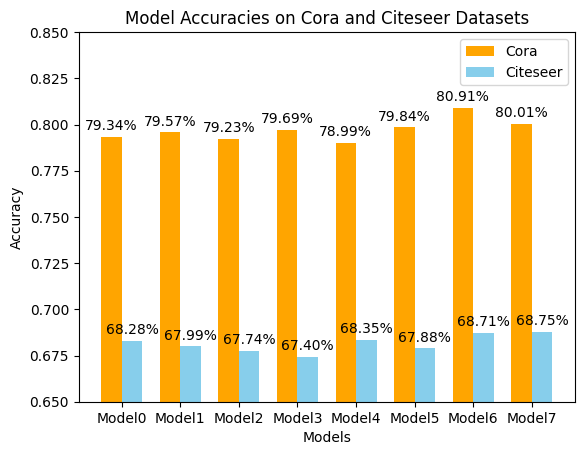

In [10]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

# Data for plotting
models = ["Model0", "Model1", "Model2", "Model3", "Model4", "Model5", "Model6", "Model7"]
architectures = ["GATL + GATL", "GATL + GATL + GATL", "GATL + TRANS + GATL", "GATL + GATL + TRANS + LIN",
                 "TRANS-A + TRANS-A", "GATL + TRANS-A + GATL", "GATL + GATL + TRANS-A", "TRANS-A + TRANS-A + TRANS-A"]
cora_accuracies = [0.7934, 0.7957, 0.7923, 0.7969, 0.7899, 0.7984, 0.8091, 0.8001]
citeseer_accuracies = [0.6828, 0.6799, 0.6774, 0.6740, 0.6835, 0.6788, 0.6871, 0.6875]

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

# Plotting
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, cora_accuracies, width, label='Cora', color='orange')
bars2 = ax.bar(x + width/2, citeseer_accuracies, width, label='Citeseer', color='skyblue')

# Adding text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracies on Cora and Citeseer Datasets')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(loc='best', bbox_to_anchor=(1, 1))

# Function to attach a label on top of each bar
def autolabel(bars):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the function to attach the labels
autolabel(bars1)
autolabel(bars2)

# Create a list of patches for the legend
architecture_patches = [Patch(facecolor='none', edgecolor='none', label=f'{model}: {arch}') 
                        for model, arch in zip(models, architectures)]

# # Add the architecture legend to the plot
# ax.legend(handles=architecture_patches, loc='best', bbox_to_anchor=(1, 1.15), title="Model Architectures")

# # Adjust the figure to accommodate the new legend
# plt.subplots_adjust(right=0.8)
ax.set_ylim(0.65, 0.85)

# Show the plot
plt.show()


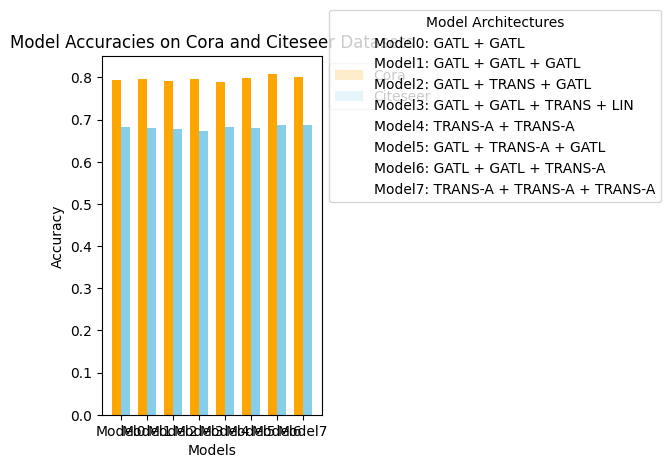

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Your existing data and plotting code
models = ["Model0", "Model1", "Model2", "Model3", "Model4", "Model5", "Model6", "Model7"]
architectures = ["GATL + GATL", "GATL + GATL + GATL", "GATL + TRANS + GATL", "GATL + GATL + TRANS + LIN",
                 "TRANS-A + TRANS-A", "GATL + TRANS-A + GATL", "GATL + GATL + TRANS-A", "TRANS-A + TRANS-A + TRANS-A"]
cora_accuracies = [0.7934, 0.7957, 0.7923, 0.7969, 0.7899, 0.7984, 0.8091, 0.8001]
citeseer_accuracies = [0.6828, 0.6799, 0.6774, 0.6740, 0.6835, 0.6788, 0.6871, 0.6875]

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, cora_accuracies, width, label='Cora', color='orange')
bars2 = ax.bar(x + width/2, citeseer_accuracies, width, label='Citeseer', color='skyblue')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracies on Cora and Citeseer Datasets')
ax.set_xticks(x)
ax.set_xticklabels(models)

# Original legend for the bars
legend1 = ax.legend(loc='best', bbox_to_anchor=(1, 1))

# Create a list of patches for the architecture legend
architecture_patches = [Patch(facecolor='none', edgecolor='none', label=f'{model}: {arch}') 
                        for model, arch in zip(models, architectures)]

# Add the architecture legend to the plot
legend2 = ax.legend(handles=architecture_patches, loc='best', bbox_to_anchor=(1, 1.15), title="Model Architectures")

# Manually add the first legend back
ax.add_artist(legend1)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
